# Import Library

In [1]:
# 기본 패키지
import os
import pandas as pd
import numpy as np

# 시각화 패키지
import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('font', family='NanumBarunGothic') 
plt.style.use(['ggplot'])

# 경고 메시지 무시
import warnings
warnings.filterwarnings(action='ignore') 

# 모델링 패키지
import eli5 
import sklearn
import matplotlib
# import pycaret
from eli5.sklearn import PermutationImportance
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import validation_curve
from sklearn.metrics import f1_score, accuracy_score, make_scorer
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from lightgbm import plot_importance

# 사용자 운영체제 확인
import platform
platform.system()

# 운영체제별 한글 폰트 설정
if platform.system() == 'Darwin': # Mac 환경 폰트 설정
    plt.rc('font', family='AppleGothic')
elif platform.system() == 'Windows': # Windows 환경 폰트 설정
    plt.rc('font', family='Malgun Gothic')

plt.rc('axes', unicode_minus=False) # 마이너스 폰트 설정


# 글씨 선명하게 출력하는 설정
%config InlineBackend.figure_format = 'retina'

# 버전 확인
print('Pandas : %s'%(pd.__version__))
print('Numpy : %s'%(np.__version__))
print('Scikit-Learn : %s'%(sklearn.__version__))
print('seaborn : %s'%(sns.__version__))
print('matplotlib : %s'%(matplotlib.__version__))
# print('pycaret : %s'%(pycaret.__version__))
!python --version

Pandas : 1.4.3
Numpy : 1.23.1
Scikit-Learn : 1.1.2
seaborn : 0.11.2
matplotlib : 3.5.3
Python 3.9.12


# Load Data

In [2]:
# 02_Data_Clustering에서 라벨링했던 데이터 불러오기
train = pd.read_csv("../data/03_Derived_Variable_train.csv")
test = pd.read_csv("../data/03_Derived_Variable_test.csv")

# Modeling

In [3]:
X_train = train.drop(columns='labels')
y_train = train['labels']
X_test = test

# train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.2, shuffle = True, stratify = y_train, random_state = 42)
# 인덱스를 지워줌
X_train, X_valid, y_train, y_valid = X_train.reset_index(drop=True), X_valid.reset_index(drop=True), y_train.reset_index(drop=True), y_valid.reset_index(drop=True)

In [4]:
print(f"X_train shape: {X_train.shape}")
print(f"X_valid shape: {X_valid.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_valid shape: {y_valid.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (20969, 34)
X_valid shape: (5243, 34)
y_train shape: (20969,)
y_valid shape: (5243,)
X_test shape: (3662, 34)


In [5]:
# 범주형 변수와 수치형 변수를 분리
## train
cat_feature_tr = X_train.iloc[:,1:].select_dtypes(include=['object']).columns.to_list()
num_feature_tr = X_train.iloc[:,1:].select_dtypes(exclude='object').columns.to_list() 
## valid
cat_feature_val = X_valid.iloc[:,1:].select_dtypes(include=['object']).columns.to_list()
num_feature_val = X_valid.iloc[:,1:].select_dtypes(exclude='object').columns.to_list()
## valid
cat_feature_te = X_test.iloc[:,1:].select_dtypes(include=['object']).columns.to_list()
num_feature_te = X_test.iloc[:,1:].select_dtypes(exclude='object').columns.to_list() 

In [6]:
# Labelencoder
encoder = LabelEncoder()
encoded_cat_tr = []
encoded_cat_val = []
encoded_cat_te = []
for f in cat_feature_tr:
    encoder = encoder.fit(pd.concat([X_train, X_valid]).reset_index(drop=True)[f])
    encoded_cat_tr.append(pd.DataFrame(encoder.transform(X_train[f]),columns = [f])) # train
    encoded_cat_val.append(pd.DataFrame(encoder.transform(X_valid[f]),columns = [f]))	# valid
    encoded_cat_te.append(pd.DataFrame(encoder.transform(X_test[f]),columns = [f]))	# test

# 합쳐줌
cat_tr = pd.concat(encoded_cat_tr, axis = 1) # train
cat_val = pd.concat(encoded_cat_val, axis = 1) # valid
cat_te = pd.concat(encoded_cat_te, axis = 1) # test

In [7]:
X_train_imp = pd.concat([X_train['고객번호'], cat_tr], axis=1)
X_valid_imp = pd.concat([X_valid['고객번호'], cat_val], axis=1)
X_test_imp = pd.concat([X_test['고객번호'], cat_te], axis=1)

X_train = pd.concat([X_train_imp, X_train[num_feature_tr]], axis=1)
X_valid = pd.concat([X_valid_imp, X_valid[num_feature_val]], axis=1)
X_test = pd.concat([X_test_imp, X_test[num_feature_te]], axis=1)

### Catboost

In [8]:
# model = RandomForestClassifier(random_state=42)
cat = CatBoostClassifier(random_state=42, verbose=0)

score = np.mean(cross_val_score(cat, X_train.iloc[:,1:], y_train, cv=5, scoring = 'f1_macro')) # 모델의 성능 확인 -> cv
score

0.6937373848289645

In [9]:
cat.fit(X_train.iloc[:,1:], y_train)
pred = cat.predict(X_valid.iloc[:,1:])

print(f"CatBoost accuracy_score: {accuracy_score(y_valid, pred)}")
print(f"CatBoost f1_score: {f1_score(y_valid, pred, average='macro')}")

CatBoost accuracy_score: 0.8785046728971962
CatBoost f1_score: 0.6579501467980087


In [10]:
perm = PermutationImportance(cat, scoring = "f1_macro", random_state = 42).fit(X_train.iloc[:,1:], y_train) 
eli5.show_weights(perm, top=10, feature_names = X_train.iloc[:,1:].columns.tolist())

Weight,Feature
0.2751 ± 0.0101,평균구매금액
0.2362 ± 0.0184,코로나확진자의최대최소차이
0.1991 ± 0.0128,코로나사망자의최대최소차이
0.1115 ± 0.0168,평균낱개구매금액
0.1086 ± 0.0077,구매월평균
0.0932 ± 0.0076,코로나신규사망자수평균
0.0771 ± 0.0172,최소구매금액
0.0757 ± 0.0049,Lpay이용여부
0.0457 ± 0.0055,평균구매일
0.0456 ± 0.0014,영수증번호길이평균


In [11]:
test_pred = cat.predict(X_test.iloc[:,1:])
cat_pred = pd.DataFrame({'고객번호': X_test.iloc[:,0], '예측유형': pd.DataFrame(test_pred)[0]})
cat_pred

,고객번호,예측유형
0,M000059535,0
1,M000658311,0
2,M000713279,0
3,M000859319,0
4,M001080017,0
...,...,...
3657,M998572907,0
3658,M999340261,0
3659,M999492154,1
3660,M999493501,0


## LightGBM

In [12]:
lgbm = LGBMClassifier(random_state=42)
score = np.mean(cross_val_score(lgbm, X_train.iloc[:,1:], y_train, cv=5, scoring = 'f1_macro')) # 모델의 성능 확인 -> cv
score

0.7089714133604734

In [13]:
lgbm.fit(X_train.iloc[:,1:], y_train)
pred = lgbm.predict(X_valid.iloc[:,1:])

print(f"LGBM accuracy_score: {accuracy_score(y_valid, pred)}")
print(f"LGBM f1_score: {f1_score(y_valid, pred, average='macro')}")

LGBM accuracy_score: 0.8798397863818425
LGBM f1_score: 0.696693569070686


In [14]:
# permutation importance 확인
perm = PermutationImportance(lgbm, scoring = "f1_macro", random_state = 42).fit(X_train.iloc[:,1:], y_train) 
eli5.show_weights(perm, top=10, feature_names = X_train.iloc[:,1:].columns.tolist())

Weight,Feature
0.3328 ± 0.0100,코로나확진자의최대최소차이
0.2768 ± 0.0066,평균구매금액
0.2376 ± 0.0112,코로나사망자의최대최소차이
0.1012 ± 0.0094,최소구매금액
0.0975 ± 0.0055,구매월평균
0.0963 ± 0.0041,코로나신규사망자수평균
0.0797 ± 0.0083,Lpay이용여부
0.0607 ± 0.0082,평균구매일
0.0553 ± 0.0071,평균낱개구매금액
0.0428 ± 0.0010,영수증번호길이평균


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

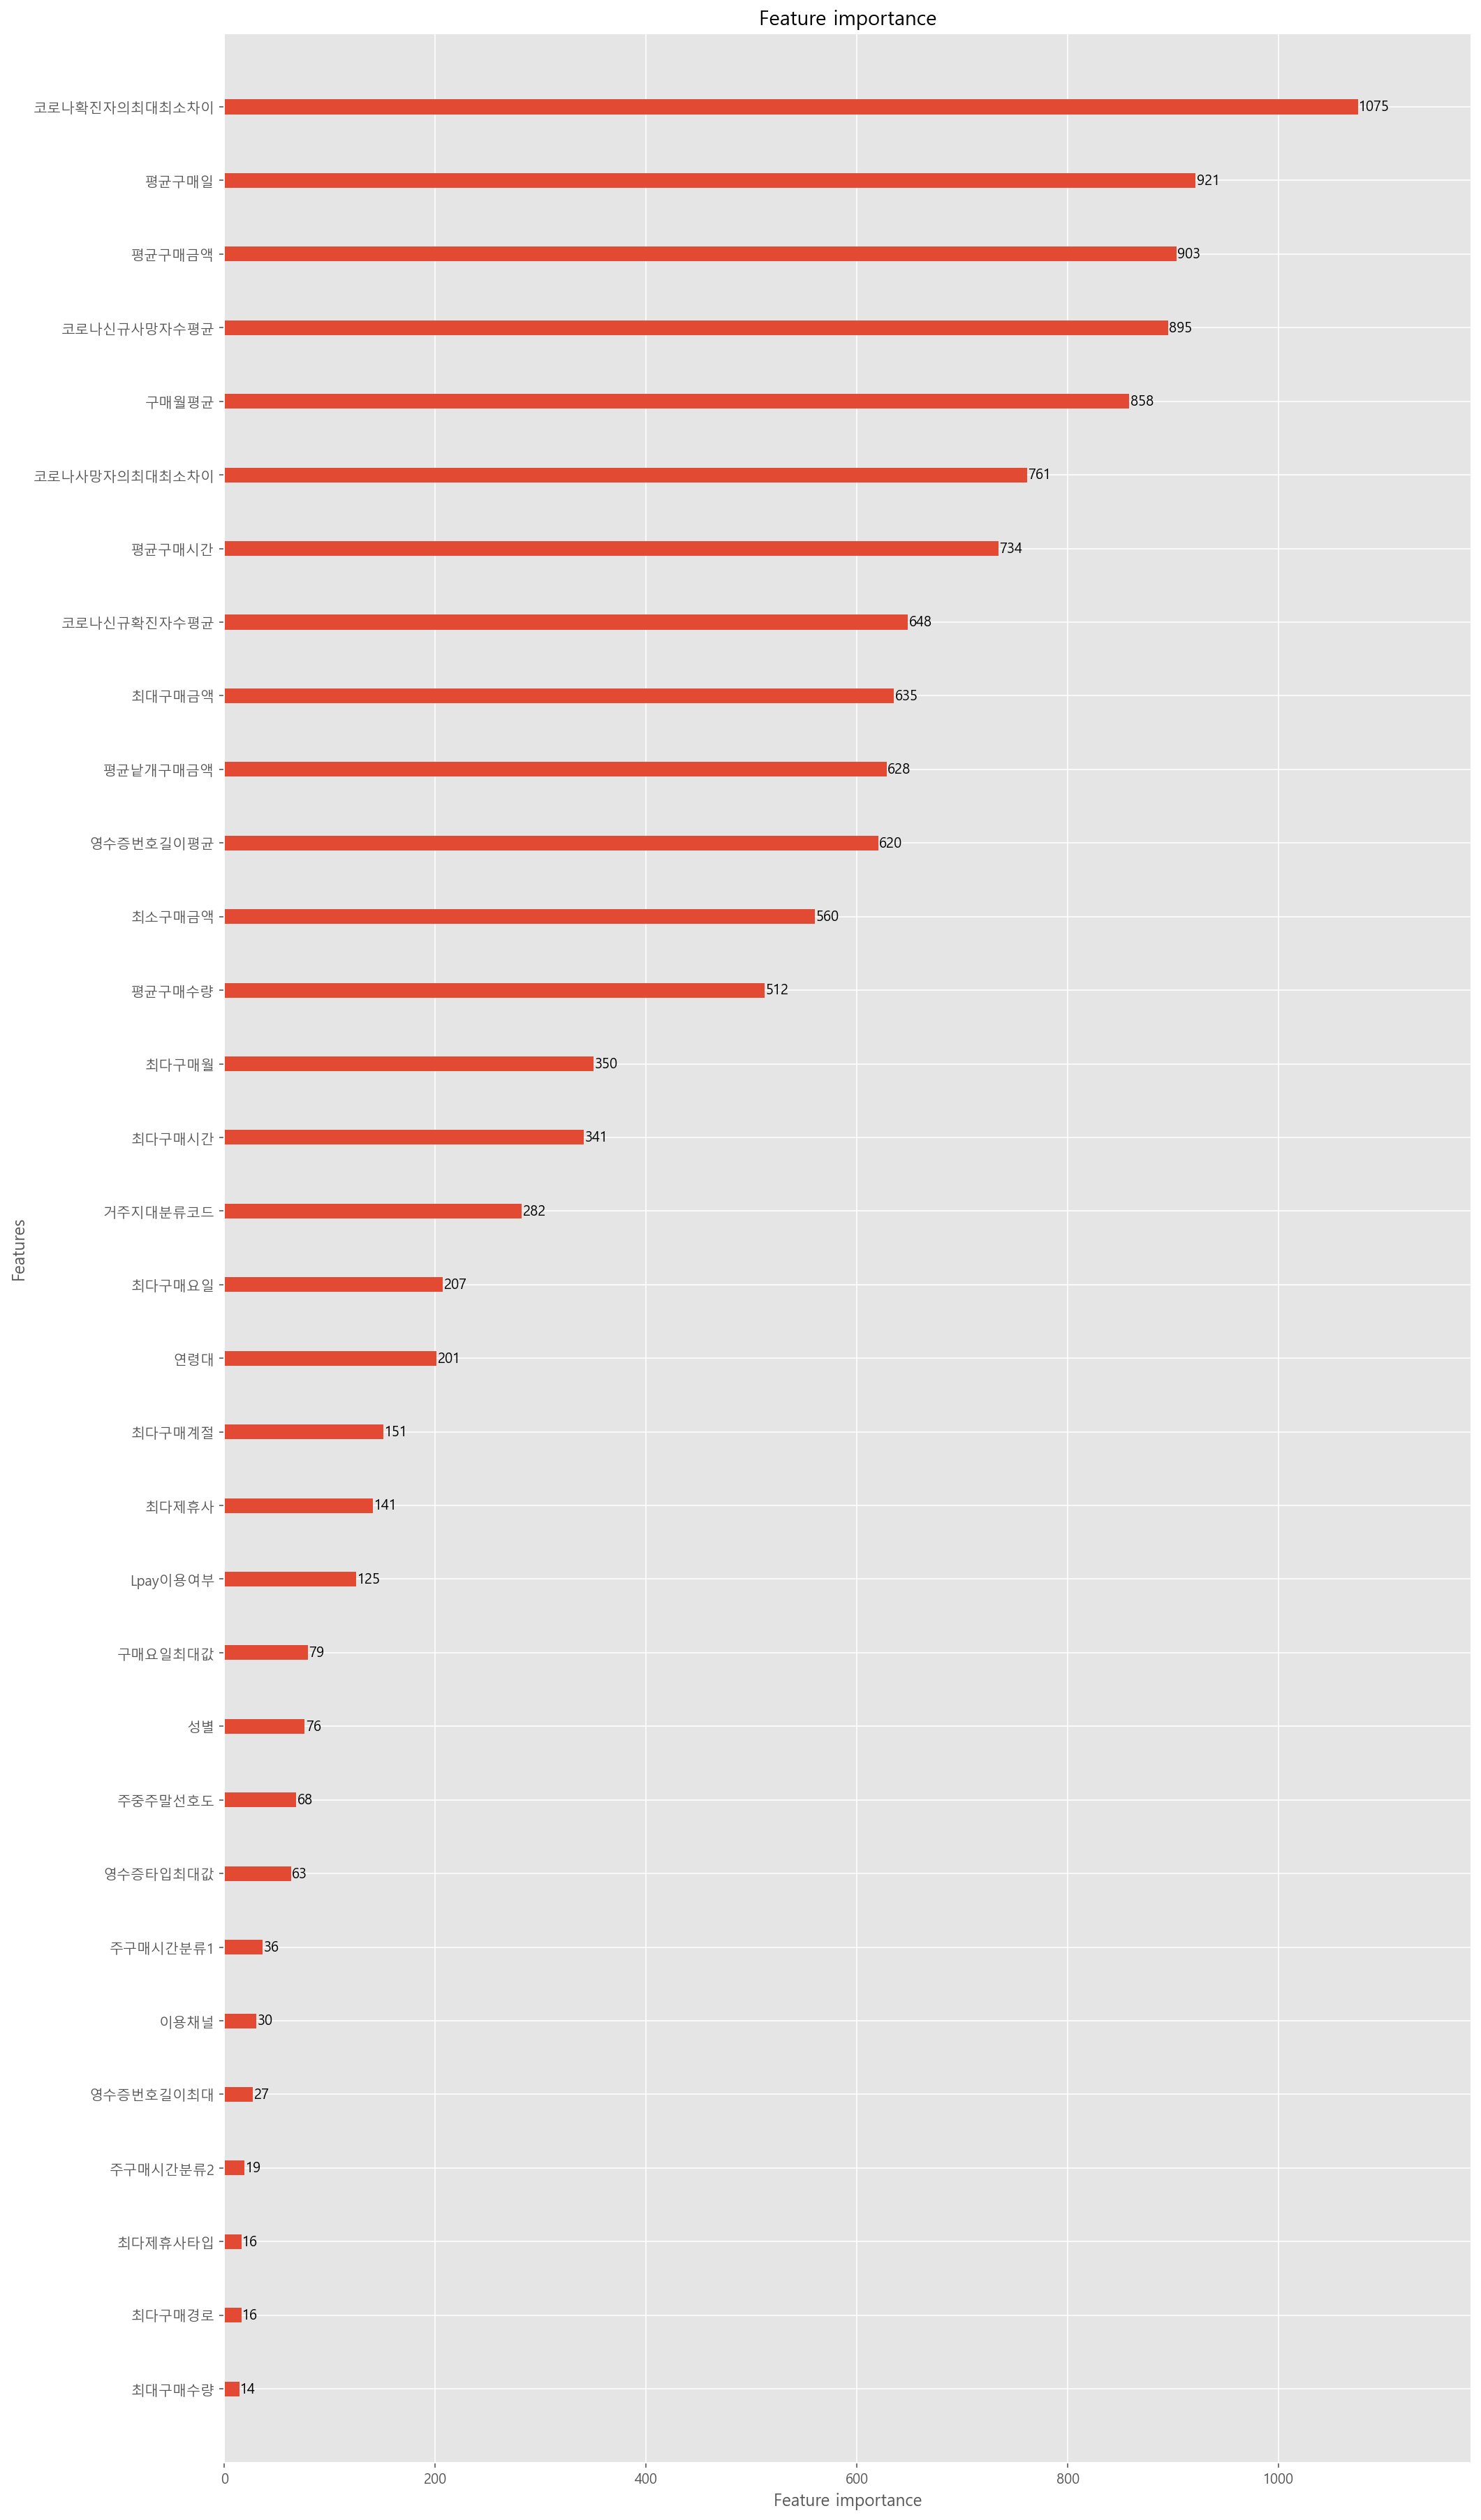

In [15]:
plot_importance(lgbm, figsize=(16, 32), max_num_features=100)

In [21]:
test_pred = lgbm.predict(X_test.iloc[:,1:])
lgbm_pred = pd.DataFrame({'고객번호': X_test.iloc[:,0], '예측유형': pd.DataFrame(test_pred)[0]})
lgbm_pred

,고객번호,예측유형
0,M000059535,0
1,M000658311,0
2,M000713279,0
3,M000859319,0
4,M001080017,0
...,...,...
3657,M998572907,0
3658,M999340261,0
3659,M999492154,1
3660,M999493501,0
